In [1]:
import sys
from argparse import ArgumentParser
from datasets import InitialConditionDataset, PDEDataset, derivatives

sys.path.append('../..')
import PINNFramework as pf

Was not able to import Horovod. Thus Horovod support is not enabled


In [2]:
import os
import h5py
import torch
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import binary_erosion

In [ ]:
path_data = "/home/zhdano82/hpmtraining/data/"

In [3]:
data_info = {
    "path_data": path_data,
    "num_t": 1000,
    "t_step": 100,
    "pix_step": 1,
    "num_x": 640,
    "num_y": 480,
    "t_min": InitialConditionDataset.load_frame(path_data, 0)[1].item(),
    "t_max": InitialConditionDataset.load_frame(path_data, 1000)[1].item(),
    "spat_res": 0.3
}

In [4]:
ic_dataset = InitialConditionDataset(
        data_info, 512, 300000)
ic_dataset.cuda()
initial_condition = pf.InitialCondition(ic_dataset)

In [5]:
low_bound = ic_dataset.low_bound.cpu()
up_bound = ic_dataset.up_bound.cpu()

heat_source_net = pf.models.MLP(input_size=2,
                                output_size=1,
                                hidden_size=200,
                                num_hidden=4,
                                lb=low_bound[:2],
                                ub=up_bound[:2])

heat_source_net.cuda()

model = pf.models.MLP(input_size=3,
                      output_size=1,
                      hidden_size=500,
                      num_hidden=8,
                      lb=low_bound,
                      ub=up_bound)
model.cuda()

hpm_model = pf.models.PennesHPM(heat_source_net)
hpm_model.cuda()

PennesHPM(
  (heat_source_net): MLP(
    (linear_layers): ModuleList(
      (0): Linear(in_features=2, out_features=200, bias=True)
      (1): Linear(in_features=200, out_features=200, bias=True)
      (2): Linear(in_features=200, out_features=200, bias=True)
      (3): Linear(in_features=200, out_features=200, bias=True)
      (4): Linear(in_features=200, out_features=200, bias=True)
      (5): Linear(in_features=200, out_features=1, bias=True)
    )
  )
)

In [19]:
pinn_path = 'pennes_d50_1k_xy_best_model_pinn.pt'
hpm_path = 'pennes_d50_1k_xy_best_model_hpm.pt'

In [20]:
model.load_state_dict(torch.load(pinn_path))

<All keys matched successfully>

In [21]:
hpm_model.load_state_dict(torch.load(hpm_path))

<All keys matched successfully>

In [23]:
def get_2d_grid(num_x, num_y):
    """
    Create a vector with all postions of a 2D grid (nx X ny )
    """
    x_values = np.arange(0, num_x, 1)
    y_values = np.arange(0, num_y, 1)

    x_grid, y_grid = np.meshgrid(x_values, y_values)

    pos_x = x_grid.reshape(-1)
    pos_y = y_grid.reshape(-1)

    return pos_x, pos_y 

def get_input(t_point, path_data, num_x, num_y, spat_res):
    """
    get the input for a specifiy point t 
    this function returns a list of grid points appended with time t
    """
    hf = h5py.File(path_data + str(t_point) + '.h5', 'r')
    t_values = np.array(hf['timing'][0])
    hf.close()

    pos_x, pos_y = get_2d_grid(num_x, num_y)

    size = pos_x.shape[0]
    pos_t = np.zeros(size) + t_values

    val_x = pos_x*spat_res
    val_y = pos_y*spat_res

    return val_x, val_y, pos_t, pos_x, pos_y

In [24]:
mask = ic_dataset.segmentation(
        data_info["path_data"],
        0,
        data_info["num_x"],
        data_info["num_y"]).T

In [488]:
t_max = 2 # model is trained on 20s data

In [489]:
def take_snapshots(option):
    
    snapshots = []
    for t_point in range(0,int(t_max/0.02),int(t_max/0.02)//40):
        x_values,y_values,t_values,x_indices,y_indices= torch.tensor(get_input(t_point, data_info['path_data'], data_info['num_x'], data_info['num_y'], data_info['spat_res']))
        X = torch.stack([x_values, y_values, t_values,x_indices,y_indices], 1).cuda().float()
        if option == -2:
            xx_yy = np.zeros(0)
        elif option == -1:
            image = model(X).cpu().detach().numpy()
        elif option == 0:
            image_hpm = np.zeros(0)
        elif option == 1:
            t_deriv = np.zeros(0)
        elif option == 2:
            hs = np.zeros(0)
        elif option == 3:
            conv = np.zeros(0)
        elif option == 4:
            perfus = np.zeros(0)
        elif option == 5:
            metab = np.zeros(0)
        else:
            raise NotImplementedError
            
        if option != -1:    
            for i in range((480*640)//512):
                X_ = X[i*512:(i+1)*512,:]
                X_.requires_grad = True
                prediction_u = model(X_)
                hpm_input = derivatives(X_, prediction_u)
                input = hpm_input[:, :-1]
                
                if option == -2:
                    u_xx_yy = hpm_input[:, -2] + hpm_input[:, -3]
                elif option == 1:
                    time_derivative = hpm_input[:, -1]
                elif option == 2:
                    heat_source = hpm_model.heat_source(input)
                elif option == 3:
                    convection = hpm_model.convection(input)
                elif option == 4:
                    perfusion = hpm_model.perfusion(input)
                elif option == 5:
                    metabolism = hpm_model.metabolism(input)

                if option == -2:
                    xx_yy = np.append(xx_yy, u_xx_yy.cpu().detach().numpy())
                elif option == 0:
                    image_hpm = np.append(image_hpm, hpm_model(hpm_input).cpu().detach().numpy())
                elif option == 1:
                    t_deriv = np.append(t_deriv, time_derivative.cpu().detach().numpy())
                elif option == 2:
                    hs = np.append(hs, heat_source.cpu().detach().numpy())
                elif option == 3:
                    conv = np.append(conv, convection.cpu().detach().numpy())
                elif option == 4:
                    perfus = np.append(perfus, perfusion.cpu().detach().numpy())
                elif option == 5:
                    metab = np.append(metab, metabolism.cpu().detach().numpy())
             
        if option == -2:
            xx_yy = xx_yy.reshape(480,640)*mask
            snapshots.append(xx_yy.reshape(-1))
        elif option == -1:        
            image = image.reshape(480,640)*mask
            snapshots.append(image.reshape(-1))
        elif option == 0:
            image_hpm = image_hpm.reshape(480,640)*mask
            snapshots.append(image_hpm.reshape(-1))
        elif option == 1:
            t_deriv = t_deriv.reshape(480,640)*mask
            snapshots.append(t_deriv.reshape(-1))
        elif option == 2:
            hs = hs.reshape(480,640)*mask
            snapshots.append(hs.reshape(-1))
        elif option == 3:
            conv = conv.reshape(480,640)*mask
            snapshots.append(conv.reshape(-1))
        elif option == 4:
            perfus = perfus.reshape(480,640)*mask
            snapshots.append(perfus.reshape(-1))
        elif option == 5:
            metab = metab.reshape(480,640)*mask
            snapshots.append(metab.reshape(-1))
            
    return snapshots

In [490]:
u = take_snapshots(-1)

In [216]:
#hpm = take_snapshots(0)
t_deriv = take_snapshots(1)
xx_yy = take_snapshots(-2)
#hs = take_snapshots(2)
#conv = take_snapshots(3)
#perfus = take_snapshots(4)
#metab = take_snapshots(5)

In [474]:
y_values = np.array(t_deriv) #du/dt

In [475]:
x_values = np.array((u-u[0])) #u(t) - u(0)

In [476]:
x1_values = np.array(xx_yy) #u_xx + u_yy

In [471]:
u_exact = ic_dataset.load_frame("/home/zhdano82/hpmtraining/data/",0)[0].reshape(640,480).T

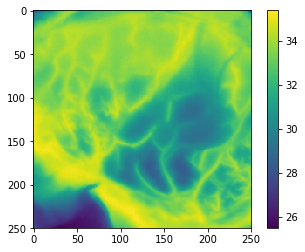

In [478]:
# Region to observe
plt.imshow(u_exact[100:350, 200:450])
plt.colorbar()

<Figure size 432x288 with 0 Axes>

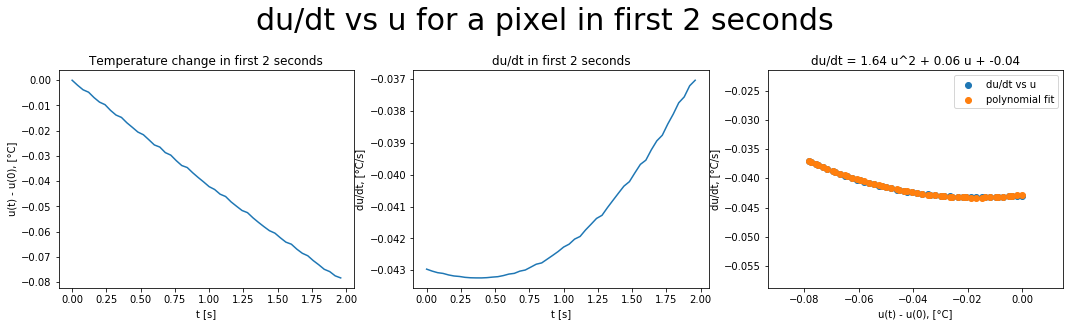

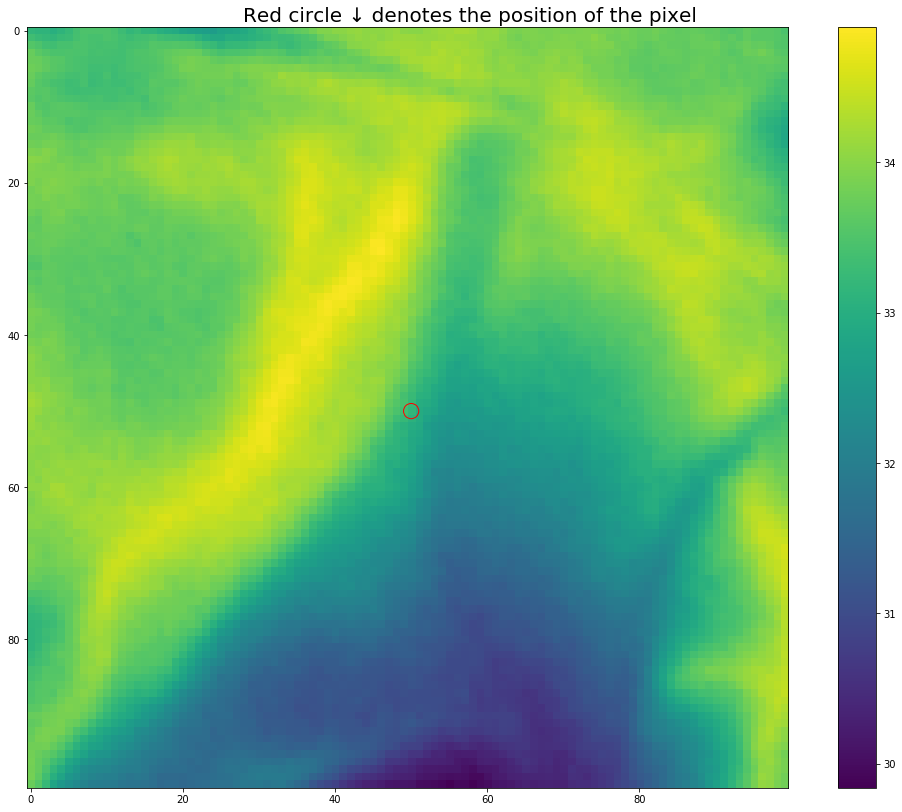

In [479]:
i = np.random.randint(100,350)
j = np.random.randint(200,450)
if mask[i,j] != 0.0:
    x = x_values.reshape(-1,480,640)[:,i,j]
    y = y_values.reshape(-1,480,640)[:,i,j]
    plt.figure(1)
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=[18,4])
    fig.suptitle('du/dt vs u for a pixel in first 2 seconds', size = 30, y = 1.10)
    ax1.plot(np.arange(0,2,2/len(x)),x)
    ax1.set_title('Temperature change in first 2 seconds')
    ax1.set(xlabel='t [s]', ylabel='u(t) - u(0), [°C]')
    ax2.plot(np.arange(0,2,2/len(y)),y)
    ax2.set_title('du/dt in first 2 seconds')
    ax2.set(xlabel='t [s]', ylabel='du/dt, [°C/s]')
    ax3.scatter(x,y, label = 'du/dt vs u')
    a,b,c = np.polyfit(x,y, deg = 2)
    ax3.scatter(x,c+b*x+a*x**2, label = 'polynomial fit')
    ax3.legend()
    ax3.set(xlabel='u(t) - u(0), [°C]', ylabel='du/dt, [°C/s]')
    ax3.set_title('du/dt = ' + str(round(a,2))+' u^2 + ' + str(round(b,2)) + ' u + ' + str(round(c,2)))
    fig, ax = plt.subplots(figsize=[18,14])
    fig.suptitle('Red circle ↓ denotes the position of the pixel', size = 20, y = 0.90)
    circle1 = plt.Circle((50, 50), 1, color='r', fill=False)
    img = ax.imshow(u_exact[i-50:i+50,j-50:j+50])
    fig.colorbar(img)
    ax.add_patch(circle1)

## Animation

In [493]:
import numpy as np
from matplotlib.animation import ArtistAnimation
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


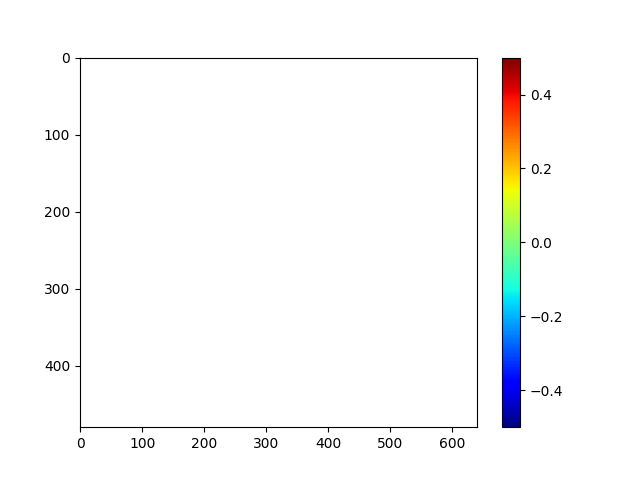

In [498]:
%matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot()
ims=[]
for iternum in range(40):
    ttl1 = plt.text(11.5, -5, str(round(iternum*t_max*0.02,1)) + ' second')
    ttl2 = plt.text(11.5, -25, 'residual') #'convection + perfusion + metabolism')
    ims.append([plt.imshow((t_deriv[iternum]).reshape(480,640), vmin = -0.5, vmax = 0.5, cmap='jet', aspect='auto'), ttl1, ttl2])
    #plt.cla()


ani = ArtistAnimation(fig, ims, interval=100, blit=False,
                              repeat_delay=100)
plt.colorbar()

<IPython.core.display.Javascript object>


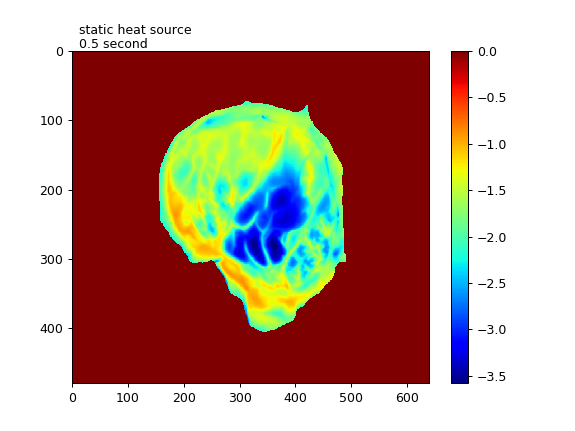

In [70]:
%matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot()
ims=[]
for iternum in range(21):
    ttl1 = plt.text(11.5, -5, str(round(iternum*25*0.02,1)) + ' second')
    ttl2 = plt.text(11.5, -25, 'static heat source') #'convection + perfusion + metabolism')
    ims.append([plt.imshow((perfus[iternum]).reshape(480,640), cmap='jet', aspect='auto'), ttl1, ttl2])
    #plt.cla()


ani = ArtistAnimation(fig, ims, interval=200, blit=False,
                              repeat_delay=10)
plt.colorbar()

Traceback (most recent call last):
  File "/trinity/shared/pkg/devel/python/3.6.5/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 215, in process
    func(*args, **kwargs)
  File "/trinity/shared/pkg/devel/python/3.6.5/lib/python3.6/site-packages/matplotlib/animation.py", line 1478, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


<IPython.core.display.Javascript object>


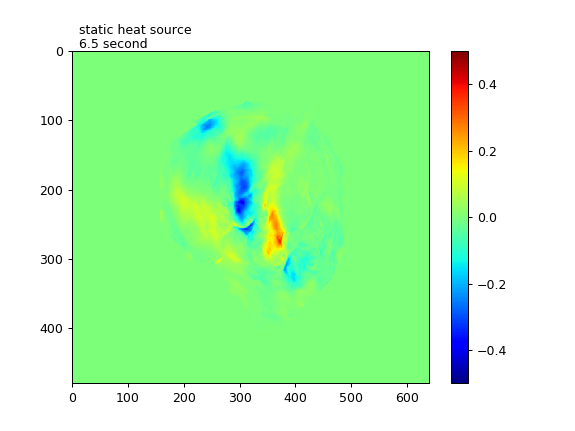

In [53]:
%matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot()
ims=[]
for iternum in range(21):
    ttl1 = plt.text(11.5, -5, str(round(iternum*25*0.02,1)) + ' second')
    ttl2 = plt.text(11.5, -25, 'static heat source') #'convection + perfusion + metabolism')
    ims.append([plt.imshow((t_deriv[iternum]).reshape(480,640), vmin = -0.5, vmax = 0.5, cmap='jet', aspect='auto'), ttl1, ttl2])
    #plt.cla()


ani = ArtistAnimation(fig, ims, interval=200, blit=False,
                              repeat_delay=10)
plt.colorbar()

## Static images

In [13]:
t_point = 100
x_values,y_values,t_values,x_indices,y_indices= torch.tensor(get_input(t_point, data_info['path_data'], data_info['num_x'], data_info['num_y'], data_info['spat_res']))
X = torch.stack([x_values, y_values, t_values,x_indices,y_indices], 1).cuda().float()

image_hpm = np.zeros(0)
t_deriv = np.zeros(0)
hs = np.zeros(0)
conv = np.zeros(0)
perfus = np.zeros(0)
metab = np.zeros(0)

for i in range((480*640)//512):
    X_ = X[i*512:(i+1)*512,:]
    X_.requires_grad = True
    prediction_u = model(X_)
    hpm_input = derivatives(X_, prediction_u)
    input = hpm_input[:, :-1]
    
    time_derivative = hpm_input[:, -1]
    heat_source = hpm_model.heat_source(input)
    convection = hpm_model.convection(input)
    perfusion = hpm_model.perfusion(input)
    metabolism = hpm_model.metabolism(input)
      
    image_hpm = np.append(image_hpm, hpm_model(hpm_input).cpu().detach().numpy())
    t_deriv = np.append(t_deriv, time_derivative.cpu().detach().numpy())
    hs = np.append(hs, heat_source.cpu().detach().numpy())
    conv = np.append(conv, convection.cpu().detach().numpy())
    perfus = np.append(perfus, perfusion.cpu().detach().numpy())
    metab = np.append(metab, metabolism.cpu().detach().numpy())

image_hpm = image_hpm.reshape(480,640)*mask
t_deriv = t_deriv.reshape(480,640)*mask
hs = hs.reshape(480,640)*mask
conv = conv.reshape(480,640)*mask
perfus = perfus.reshape(480,640)*mask
metab = metab.reshape(480,640)*mask

/trinity/shared/pkg/devel/python/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in multiply
/trinity/shared/pkg/devel/python/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in multiply


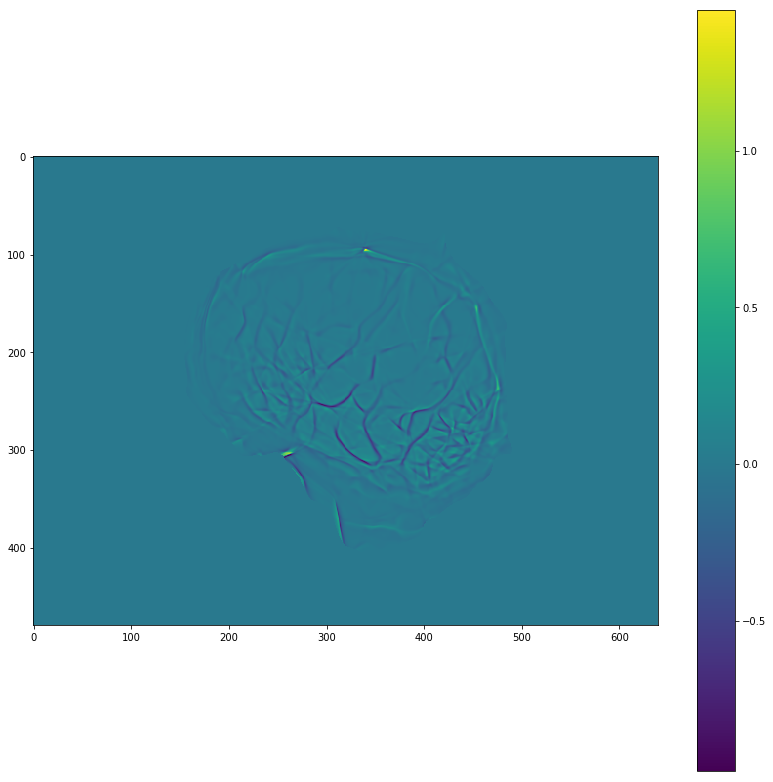

In [14]:
plt.figure(figsize=[14,14])
plt.imshow(conv)
plt.colorbar()

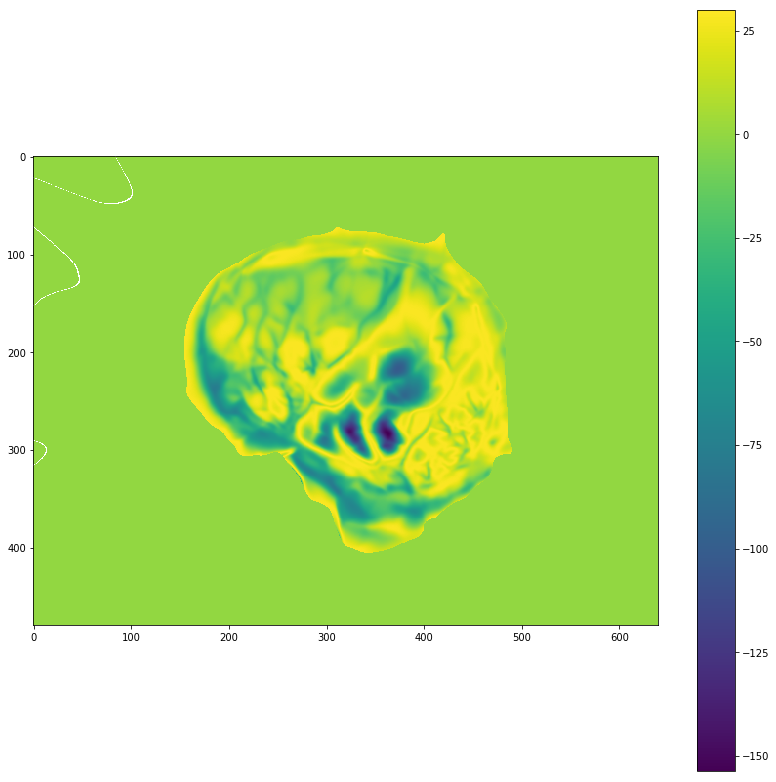

In [16]:
plt.figure(figsize=[14,14])
plt.imshow(image_hpm)
plt.colorbar()

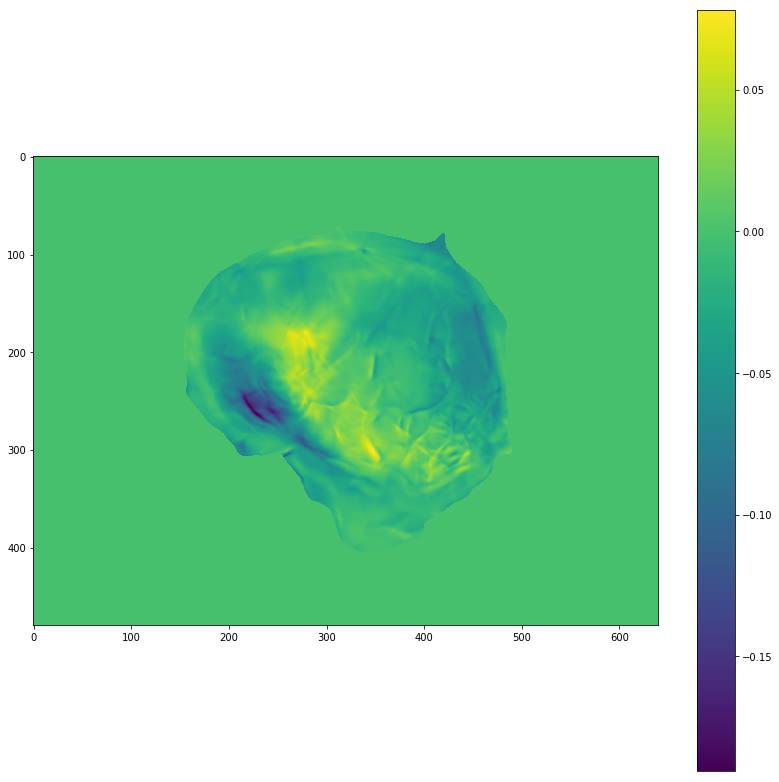

In [17]:
plt.figure(figsize=[14,14])
plt.imshow(t_deriv)
plt.colorbar()

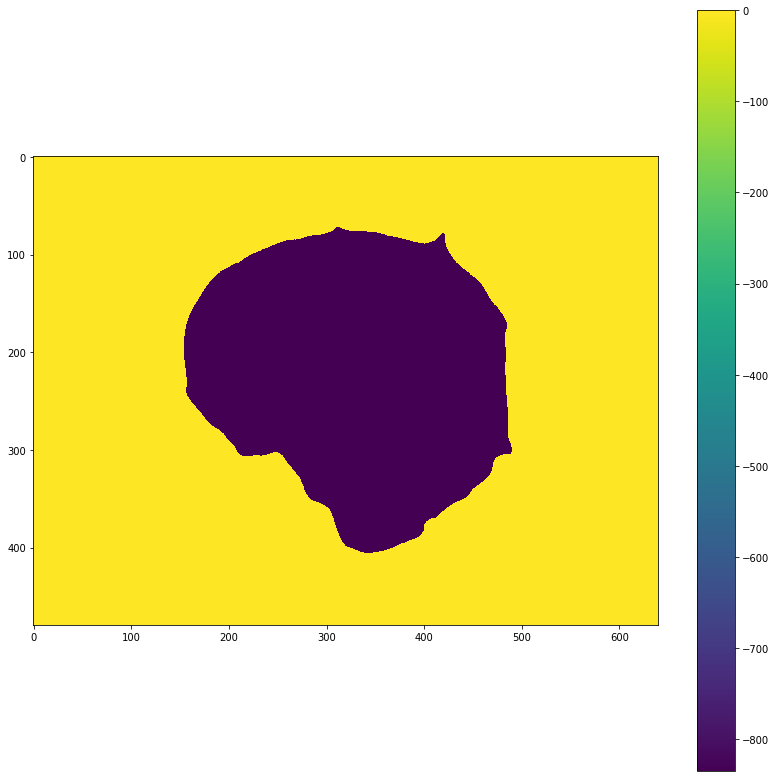

In [18]:
plt.figure(figsize=[14,14])
plt.imshow(hs)
plt.colorbar()

## Collages

In [15]:
def make_snapshots(t_point):
    x_values,y_values,t_values,x_indices,y_indices= torch.tensor(get_input(t_point, data_info['path_data'], data_info['num_x'], data_info['num_y'], data_info['spat_res']))
    X = torch.stack([x_values, y_values, t_values,x_indices,y_indices], 1).cuda().float()
    image_hpm = np.zeros(0)
    image_alpha = np.zeros(0)
    image_hs = np.zeros(0)
    deriv_sum = np.zeros(0)
    t_deriv = np.zeros(0)
    xx_deriv = np.zeros(0)
    yy_deriv = np.zeros(0)
    diffusion = np.zeros(0)
    image = model(X)
    for i in range((480*640)//512):
        X_ = X[i*512:(i+1)*512,:]
        k = k_values.T.reshape(-1)[i*512:(i+1)*512]
        X_.requires_grad = True
        prediction_u = model(X_)
        hpm_input = derivatives(X_, prediction_u)
        xx_derivative = hpm_input[:, -3]
        yy_derivative = hpm_input[:, -2]
        time_derivative = hpm_input[:, -1]
        diffus = (xx_derivative.cpu().detach().numpy()+yy_derivative.cpu().detach().numpy())*k
        input = hpm_input[:, :-1]
        hpm_output = hpm_model(input)
        image_hpm = np.append(image_hpm, hpm_model(hpm_input).cpu().detach().numpy())
        image_hs = np.append(image_hs, heat_source_net(X_[:,:3]).cpu().detach().numpy())
        t_deriv = np.append(t_deriv, time_derivative.cpu().detach().numpy())
        xx_deriv = np.append(xx_deriv, xx_derivative.cpu().detach().numpy())
        yy_deriv = np.append(yy_deriv, yy_derivative.cpu().detach().numpy())
        diffusion = np.append(diffusion, diffus)

        
    image = image.reshape(480,640).cpu().detach().numpy()*mask
    image_hs = image_hs.reshape(480,640)*mask
    image_hpm = image_hpm.reshape(480,640)*mask
    t_deriv = t_deriv.reshape(480,640)*mask
    xx_deriv = xx_deriv.reshape(480,640)*mask
    yy_deriv = yy_deriv.reshape(480,640)*mask
    diffusion = diffusion.reshape(480,640)*mask

    return image, image_hs, image_hpm, t_deriv, xx_deriv, yy_deriv, diffusion

In [21]:
image0, image_hs0, image_hpm0, t_deriv0, xx_deriv0, yy_deriv0, diffusion0 = make_snapshots(0)
image1, image_hs1, image_hpm1, t_deriv1, xx_deriv1, yy_deriv1, diffusion1 = make_snapshots(125)
image2, image_hs2, image_hpm2, t_deriv2, xx_deriv2, yy_deriv2, diffusion2 = make_snapshots(250)
image3, image_hs3, image_hpm3, t_deriv3, xx_deriv3, yy_deriv3, diffusion3 = make_snapshots(375)
image4, image_hs4, image_hpm4, t_deriv4, xx_deriv4, yy_deriv4, diffusion4 = make_snapshots(500)
image5, image_hs5, image_hpm5, t_deriv5, xx_deriv5, yy_deriv5, diffusion5 = make_snapshots(625)
image6, image_hs6, image_hpm6, t_deriv6, xx_deriv6, yy_deriv6, diffusion6 = make_snapshots(750)
image7, image_hs7, image_hpm7, t_deriv7, xx_deriv7, yy_deriv7, diffusion7 = make_snapshots(875)

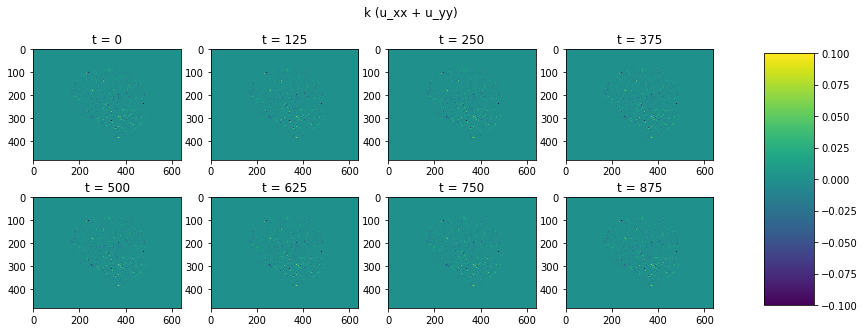

In [208]:
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=[14,5])
ax1.imshow(diffusion0, vmin = -0.1, vmax = 0.1)
ax1.title.set_text('t = ' + str(0))
ax2.imshow(diffusion1, vmin = -0.1, vmax = 0.1)
ax2.title.set_text('t = ' + str(125))
ax3.imshow(diffusion2, vmin = -0.1, vmax = 0.1)
ax3.title.set_text('t = ' + str(250))
ax4.imshow(diffusion3, vmin = -0.1, vmax = 0.1)
ax4.title.set_text('t = ' + str(375))
ax5.imshow(diffusion4, vmin = -0.1, vmax = 0.1)
ax5.title.set_text('t = ' + str(500))
ax6.imshow(diffusion5, vmin = -0.1, vmax = 0.1)
ax6.title.set_text('t = ' + str(625))
ax7.imshow(diffusion6, vmin = -0.1, vmax = 0.1)
ax7.title.set_text('t = ' + str(750))
ax8.imshow(diffusion7, vmin = -0.1, vmax = 0.1)
ax8.title.set_text('t = ' + str(875))
im = ax8.imshow(diffusion7, vmin = -0.1, vmax = 0.1)

fig.suptitle('k (u_xx + u_yy)')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
fig.savefig('diffusion.png',dpi=500)

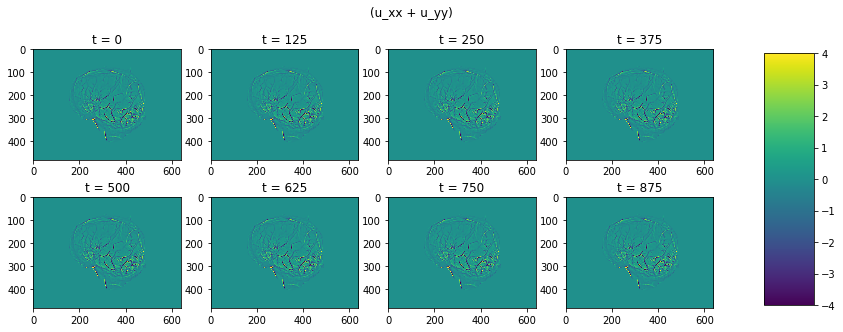

In [209]:
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=[14,5])
ax1.imshow(xx_deriv0+yy_deriv0, vmin = -4, vmax = 4)
ax2.imshow(xx_deriv1+yy_deriv1, vmin = -4, vmax = 4)
ax3.imshow(xx_deriv2+yy_deriv2, vmin = -4, vmax = 4)
ax4.imshow(xx_deriv3+yy_deriv3, vmin = -4, vmax = 4)
ax5.imshow(xx_deriv4+yy_deriv4, vmin = -4, vmax = 4)
ax6.imshow(xx_deriv5+yy_deriv5, vmin = -4, vmax = 4)
ax7.imshow(xx_deriv6+yy_deriv6, vmin = -4, vmax = 4)
ax8.imshow(xx_deriv7+yy_deriv7, vmin = -4, vmax = 4)
im = ax8.imshow(xx_deriv7+yy_deriv7, vmin = -4, vmax = 4)
ax1.title.set_text('t = ' + str(0))
ax2.title.set_text('t = ' + str(125))
ax3.title.set_text('t = ' + str(250))
ax4.title.set_text('t = ' + str(375))
ax5.title.set_text('t = ' + str(500))
ax6.title.set_text('t = ' + str(625))
ax7.title.set_text('t = ' + str(750))
ax8.title.set_text('t = ' + str(875))
fig.suptitle('(u_xx + u_yy)')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
fig.savefig('xx_yy.png',dpi=500)

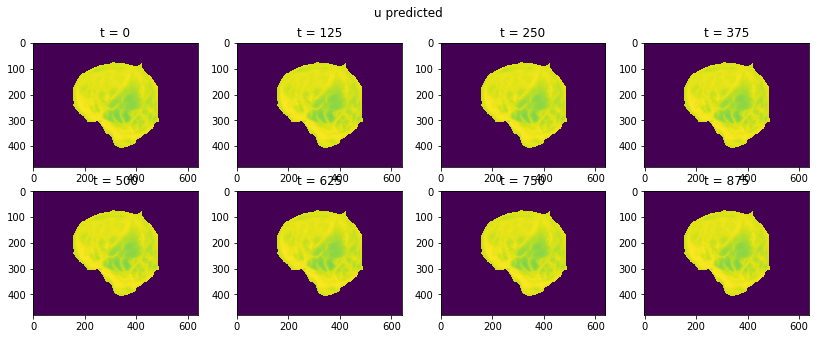

In [210]:
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=[14,5])
ax1.imshow(image0)
ax2.imshow(image1)
ax3.imshow(image2)
ax4.imshow(image3)
ax5.imshow(image4)
ax6.imshow(image5)
ax7.imshow(image6)
ax8.imshow(image7)
ax1.title.set_text('t = ' + str(0))
ax2.title.set_text('t = ' + str(125))
ax3.title.set_text('t = ' + str(250))
ax4.title.set_text('t = ' + str(375))
ax5.title.set_text('t = ' + str(500))
ax6.title.set_text('t = ' + str(625))
ax7.title.set_text('t = ' + str(750))
ax8.title.set_text('t = ' + str(875))
fig.suptitle('u predicted')
fig.savefig('image.png',dpi=500)

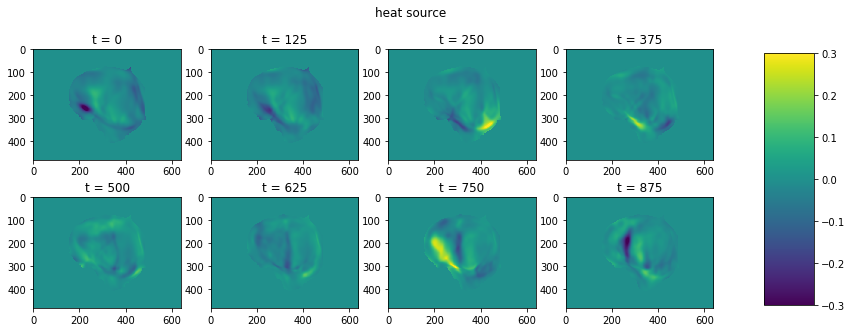

In [211]:
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=[14,5])
ax1.imshow(image_hs0, vmin = -0.3, vmax = 0.3)
ax2.imshow(image_hs1, vmin = -0.3, vmax = 0.3)
ax3.imshow(image_hs2, vmin = -0.3, vmax = 0.3)
ax4.imshow(image_hs3, vmin = -0.3, vmax = 0.3)
ax5.imshow(image_hs4, vmin = -0.3, vmax = 0.3)
ax6.imshow(image_hs5, vmin = -0.3, vmax = 0.3)
ax7.imshow(image_hs6, vmin = -0.3, vmax = 0.3)
ax8.imshow(image_hs7, vmin = -0.3, vmax = 0.3)
ax1.title.set_text('t = ' + str(0))
ax2.title.set_text('t = ' + str(125))
ax3.title.set_text('t = ' + str(250))
ax4.title.set_text('t = ' + str(375))
ax5.title.set_text('t = ' + str(500))
ax6.title.set_text('t = ' + str(625))
ax7.title.set_text('t = ' + str(750))
ax8.title.set_text('t = ' + str(875))
im = ax8.imshow(image_hs7, vmin = -0.3, vmax = 0.3)
fig.suptitle('heat source')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
fig.savefig('image_hs.png',dpi=500)

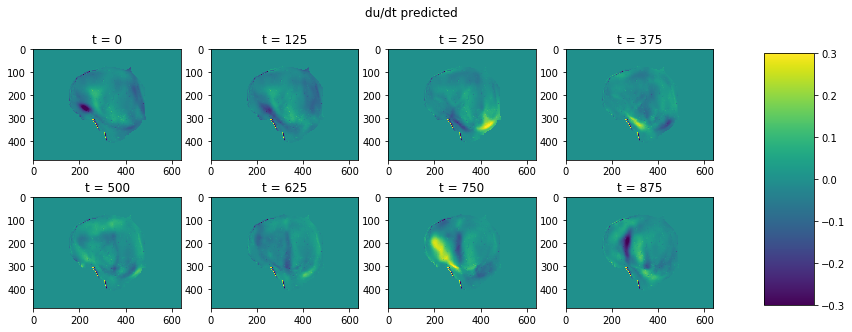

In [212]:
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=[14,5])
ax1.imshow(image_hpm0, vmin = -0.3, vmax = 0.3)
ax2.imshow(image_hpm1, vmin = -0.3, vmax = 0.3)
ax3.imshow(image_hpm2, vmin = -0.3, vmax = 0.3)
ax4.imshow(image_hpm3, vmin = -0.3, vmax = 0.3)
ax5.imshow(image_hpm4, vmin = -0.3, vmax = 0.3)
ax6.imshow(image_hpm5, vmin = -0.3, vmax = 0.3)
ax7.imshow(image_hpm6, vmin = -0.3, vmax = 0.3)
ax8.imshow(image_hpm7, vmin = -0.3, vmax = 0.3)
ax1.title.set_text('t = ' + str(0))
ax2.title.set_text('t = ' + str(125))
ax3.title.set_text('t = ' + str(250))
ax4.title.set_text('t = ' + str(375))
ax5.title.set_text('t = ' + str(500))
ax6.title.set_text('t = ' + str(625))
ax7.title.set_text('t = ' + str(750))
ax8.title.set_text('t = ' + str(875))
im = ax8.imshow(image_hpm7, vmin = -0.3, vmax = 0.3)
fig.subplots_adjust(right=0.8)
fig.suptitle('du/dt predicted')

cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
fig.savefig('dudt_pred.png',dpi=500)

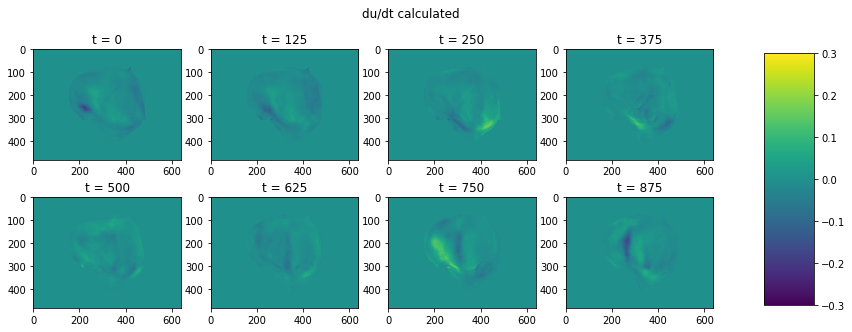

In [213]:
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=[14,5])
ax1.imshow(t_deriv0, vmin = -0.3, vmax = 0.3)
ax2.imshow(t_deriv1, vmin = -0.3, vmax = 0.3)
ax3.imshow(t_deriv2, vmin = -0.3, vmax = 0.3)
ax4.imshow(t_deriv3, vmin = -0.3, vmax = 0.3)
ax5.imshow(t_deriv4, vmin = -0.3, vmax = 0.3)
ax6.imshow(t_deriv5, vmin = -0.3, vmax = 0.3)
ax7.imshow(t_deriv6, vmin = -0.3, vmax = 0.3)
ax8.imshow(t_deriv7, vmin = -0.3, vmax = 0.3)
ax1.title.set_text('t = ' + str(0))
ax2.title.set_text('t = ' + str(125))
ax3.title.set_text('t = ' + str(250))
ax4.title.set_text('t = ' + str(375))
ax5.title.set_text('t = ' + str(500))
ax6.title.set_text('t = ' + str(625))
ax7.title.set_text('t = ' + str(750))
ax8.title.set_text('t = ' + str(875))
im = ax8.imshow(t_deriv7, vmin = -0.3, vmax = 0.3)
fig.suptitle('du/dt calculated')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
fig.savefig('dudt_calc.png',dpi=500)

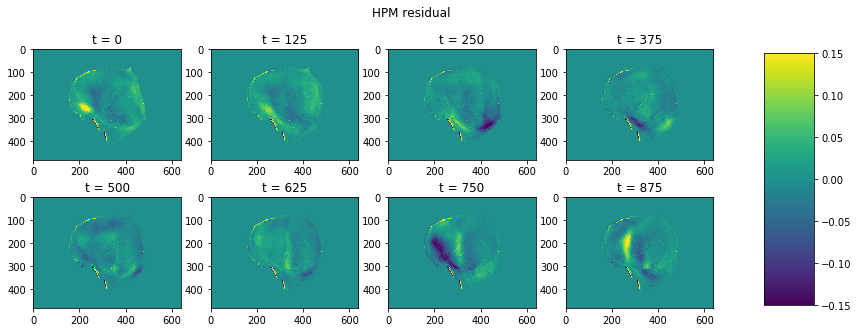

In [214]:
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=[14,5])
ax1.imshow(t_deriv0-image_hpm0, vmin = -0.15, vmax=0.15)
ax2.imshow(t_deriv1-image_hpm1, vmin = -0.15, vmax=0.15)
ax3.imshow(t_deriv2-image_hpm2, vmin = -0.15, vmax=0.15)
ax4.imshow(t_deriv3-image_hpm3, vmin = -0.15, vmax=0.15)
ax5.imshow(t_deriv4-image_hpm4, vmin = -0.15, vmax=0.15)
ax6.imshow(t_deriv5-image_hpm5, vmin = -0.15, vmax=0.15)
ax7.imshow(t_deriv6-image_hpm6, vmin = -0.15, vmax=0.15)
ax8.imshow(t_deriv7-image_hpm7, vmin = -0.15, vmax=0.15)
ax1.title.set_text('t = ' + str(0))
ax2.title.set_text('t = ' + str(125))
ax3.title.set_text('t = ' + str(250))
ax4.title.set_text('t = ' + str(375))
ax5.title.set_text('t = ' + str(500))
ax6.title.set_text('t = ' + str(625))
ax7.title.set_text('t = ' + str(750))
ax8.title.set_text('t = ' + str(875))
fig.suptitle('HPM residual')

im = ax8.imshow(t_deriv7-image_hpm7, vmin = -0.15, vmax=0.15)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
fig.savefig('residual.png',dpi=500)

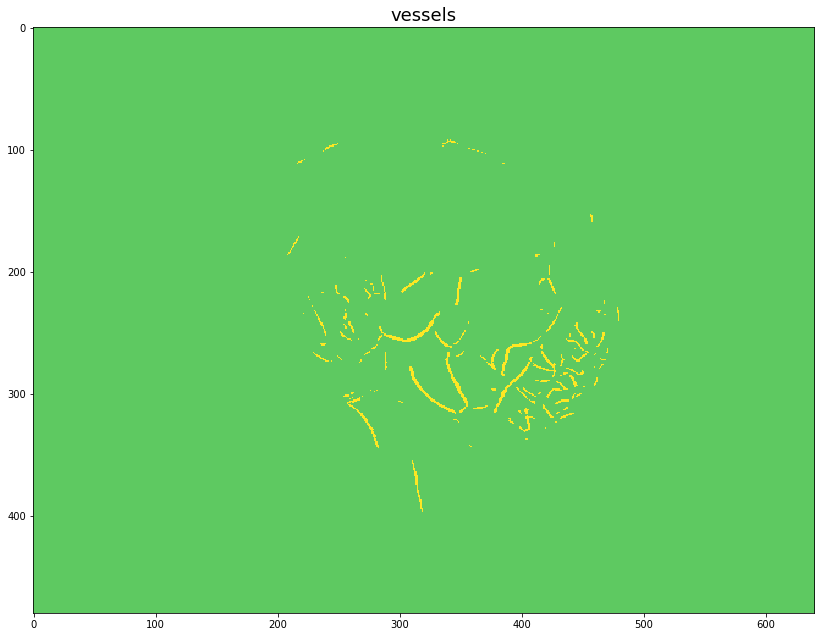

In [45]:
plt.figure(figsize=[14,14])
plt.imshow((xx_deriv0+yy_deriv0)<-2, vmin = -3, vmax = 1)
plt.title('vessels', size = 18);
#plt.colorbar(fraction=0.035, pad=0.04)

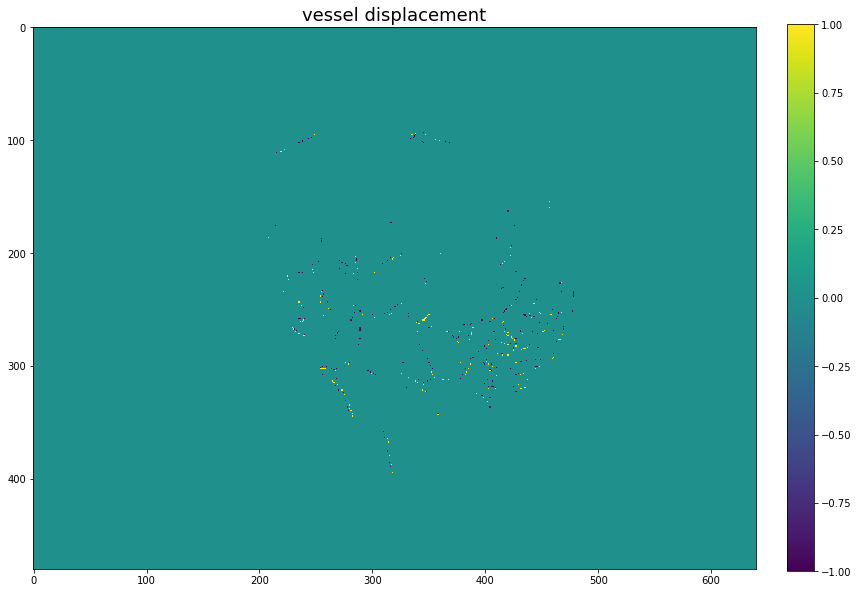

In [43]:
plt.figure(figsize=[14,14])
plt.imshow(((xx_deriv0+yy_deriv0)<-2)*1-((xx_deriv7+yy_deriv7)<-2)*1, vmin = -1, vmax = 1)
plt.title('vessel displacement', size = 18);
plt.colorbar(fraction=0.035, pad=0.04)